In [42]:
import numpy as np
from IPython.display import Latex

from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

# Deutsch Problem

The Deutsch Problem is a simple "toy" example of how a problem that takes exponential time in classical computing takes only polynomial time when solved (in a fundamentally different way) with quantum computing. In this notebook, we'll look at the Deutsch problem at a high level, as well as the generalization to the Deutsch-Jozsa problem.

## Problem Description

Take a binary map function $f: x \in \{0,1\} \rightarrow f(x) = y \in \{0,1\}$. Any function $f$ can be **constant** or **balanced**, defined as:

* Balanced: $f(x)$ yields the same result for all inputs; $\forall\ x \in \{0, 1\},\ \ f(x) = y$
  * For the simple 1-bit input, this corresponds to 2 possible definitions of $f$:
    * $f(x) = 0$
    * $f(x) = 1$
* Constant: $f(x)$ yields 0 for half of inputs, and 1 for the other half
  * For the simple 1-bit input, this corresponds to 2 possible definitions of $f$:
    * $f(x) = x$
    * $f(x) = \bar{x} = x \oplus 1$, where $\oplus$ is XOR/addition modulo 2 ("flip the bit")
    
In the Deutsch problem, we aim to find out whether a given function $f$ is constant or balanced.

## Classical Solution

How do we solve the Deutsch problem with classical computers? We must evaluate the function $f$ for both possible inputs, as we can't tell if $f$ is constant or balanced without knowing what both outputs are. For example, given a function $f$, first we evaluate $f(0)$ = 1. We can't tell if the function is constant or balanced, but we can after evaluating $f(1)$.

Let's define the functions above in Python and choose one to evaluate at random. Can you tell whether the function is constant or balanced after evaluating only $f(0)$?

In [43]:
f1 = lambda x: 0
f2 = lambda x: 1
f3 = lambda x: x
f4 = lambda x: (x + 1) % 2

funcs = [f1, f2, f3, f4]

In [44]:
test_func = funcs[np.random.randint(4)]
test_func(0)

1

In [45]:
test_func(1)

1

## Quantum Solution

We've now demonstrated that the classical solution to the Deutsch problem requires 2 executions. However, with quantum computing, we make this determination by evaluating the function **only one time** by leveraging superposition to effectively, garner some global knowledge about the function as if it were applied to all inputs simultaneously. Let's explore how this is done.

### Oracle Functions

Firstly, we must set up our problem in a way that is compatible with quantum computers. Specifically, we need to be able to run our function $f$ such that it:

* Operates on Qubits
* Is reversible

To do this, we need to use a 2-qubit system (of qubits $x$ and $y$) and a 2 qubit matrix to represent the function $f$. We need the additional (ancilla) qubit in order to ensure that the function is reversible when applied to the quantum circuit. We refer to this matrix representation of the function we are evaluating as the **oracle function** $U_f$. In order to be reversible, this 2 qubit system needs to operate as follows:

$$
U_f: |x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x)\rangle
$$

### Circuit Setup

The quantum circuit used to solve the Deutsch problem is pictured below:

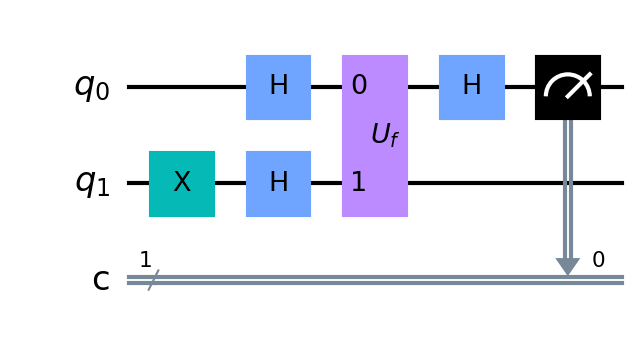

In [46]:
circuit = QuantumCircuit(2, 1)
circuit.x(1)
circuit.h((0,1))
circuit.unitary(np.identity(4), (0,1), '$U_f$') # 4x4 identity matrix as example
circuit.h(0)
circuit.measure(0, 0)
circuit.draw('mpl', justify='right', scale=1.5)

This circuit consists of the following (in order):

* Input qubit ($|x\rangle$, $q_0$) initialized to $|0\rangle$
* Ancilla qubit ($|y\rangle$, $q_1$) initialized to $|1\rangle$ (IE, with $X$ gate)
* Hadamard gates applied to each qubit
* 2-qubit oracle/unitary function $U_f$
* Final Hadamard gate applied to $q_0$
* Measurement of $q_0$

Without going into many details (and mathderivation), when we execute this circuit, we can discover whether the function is constant or balanced as follows:

* If $q_0$ is measured to be 0, then the function is guaranteed to be constant.
* If $q_0$ is measured to be 1, then the function is guaranteed to be balanced.

Let's look at some examples of this in action.

## Example

For this example, we'll use $f(x) = x$ as our "balanced" function. The logic table of the function, is as follows:

| $$x$$ | $$f(x)$$ |
|:-:|:----:|
| 0 | 0 |
| 1 | 1 |

Let's extend this table to include the second qubit and the result of the orcale function $U_f$ when evaluating this function:

| $$x$$ | $$y$$ | $$f(x)$$ | $$y \oplus f(x)$$ |
|:-----:|:-----:|:--------:|:-----------------:|
|   0   |   0   |    0     |         0         |
|   0   |   1   |    0     |         1         |
|   1   |   0   |    1     |         1         |
|   1   |   1   |    1     |         0         |

Conveniently, we can represent this function with the CNOT gate, as it implements this exact logic table. So, for this function, $U_f = CNOT$ We can manually compute the different states of a 2-qubit system when operated on by the CNOT gate below:

In [51]:
# Gate definitions
cnot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
cnot

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [52]:
# Showing how CNOT gate changes basis states for a 2-qubit system
result_table = []
for index in range(4):
    instate = np.array([[1 if j == index else 0] for j in range(4)])
    result = cnot @ instate
    result_table.append((instate, result))

for result_tuple in result_table:
    instate_tex = Statevector(result_tuple[0]).draw('latex_source')
    result_tex = Statevector(result_tuple[1]).draw('latex_source')
    display(Latex('$CNOT \otimes {} = {}$'.format(instate_tex, result_tex)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

From the output above, we can see that the CNOT gate, when applied to different 2-qubit state vectors, matches our logic table above.

Let's actually evaluate whether or not this function is balanced using the circuit we defined before. Here's our updated circuit using the CNOT gate as $U_f$:

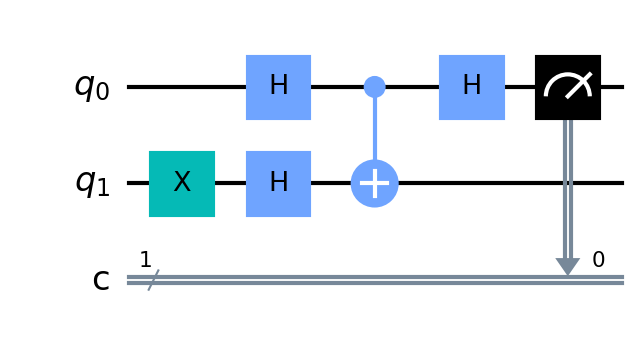

In [83]:
circuit = QuantumCircuit(2, 1)
circuit.x(1)
circuit.h((0, 1))
circuit.cnot(0, 1)
# circuit.unitary(np.identity(4, int), (0, 1), 'Identity')
circuit.h(0)
circuit.measure(0, 0)
circuit.draw('mpl', justify='right', scale=1.5)

In [85]:
circuit.qubits[0]

Qubit(QuantumRegister(2, 'q'), 0)

When we actually execute this circuit (1,024 times), we can observe the results:

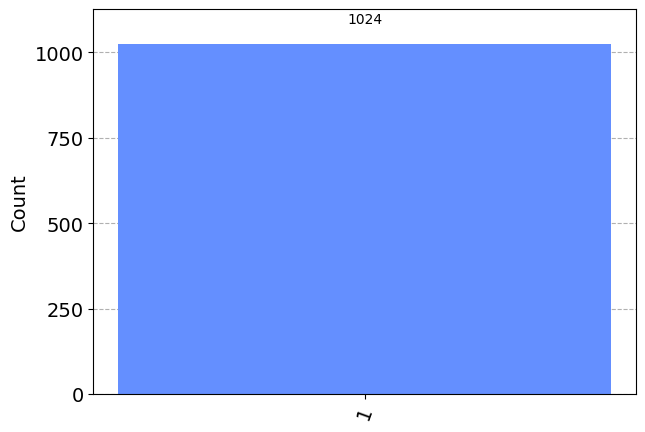

In [86]:
sim_backend = Aer.get_backend('qasm_simulator')

job = sim_backend.run(transpile(circuit, sim_backend), shots=1024)
result = job.result()

counts = result.get_counts()

plot_histogram(counts)

And we see that the result is 1, so we can conclude that our function $f(x) = x$ is indeed balanced, by only evaluating the circuit **a single time!**

## Why Does this Work?